In [1]:
!pip install celerite

  Using cached https://files.pythonhosted.org/packages/b7/9d/fcef6bbf7ba06cfb5bcab3d3fd4e3f3c8b6f16c6fb97e632f7898f77bc57/celerite-0.3.1.tar.gz
  Created wheel for celerite: filename=celerite-0.3.1-cp37-cp37m-linux_x86_64.whl size=390361 sha256=dcff2cf287eb4fba7b6f5eab0046f85b1a7ce0197652f9750cf5fa6cb6ad3858
  Stored in directory: /home/amir/.cache/pip/wheels/5b/63/3d/17cc0faa6816077dbb619af4761d6bed6a536e4d19e5b2cb92
Successfully built celerite


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from advanced_sampling_utils import setup_plotting
setup_plotting()
# Basic scientific Python modules 
import scipy.stats
import celerite
# For plotting: https://corner.readthedocs.io
import corner

# Sampling modules:
import emcee

In [30]:
# Params
t = np.arange(0, 27, 1.0 / 24.0 / 60.0)
nreg = 100
log_S0 = 7.0
log_Q = -2.0
log_w0 = 0.0
lam = 1e-3
flux_err = 1.0
t0 = 12.0
sig_t = 0.15

# Value we want to recover
depth_true = 2.0

# Build the noise design matrix
kernel = celerite.terms.SHOTerm(log_S0=log_S0, log_Q=log_Q, log_omega0=log_w0)
gp = celerite.GP(kernel)
gp.compute(t)
A = gp.sample(size=nreg).T
A -= np.mean(A, axis=0).reshape(1, -1)

# Randomize a weight vector
w_true = np.sqrt(lam) * np.random.randn(nreg)

# The transit model
A_trn = -np.exp(-(t - t0) ** 2 / sig_t ** 2).reshape(-1, 1)

# Weight vector
w_trn = [depth_true]

# Add noise
flux = A.dot(w_true) + A_trn.dot(w_trn) + flux_err * np.random.randn(len(t))

# Save
data = {
    'time': t, 
    'flux': flux,
    'flux_err': flux_err,
}
for n in range(nreg):
    data.update({"A%03d" % n: A[:, n]})
df = pd.DataFrame(data)
df.to_csv("problem2.csv", index=False)

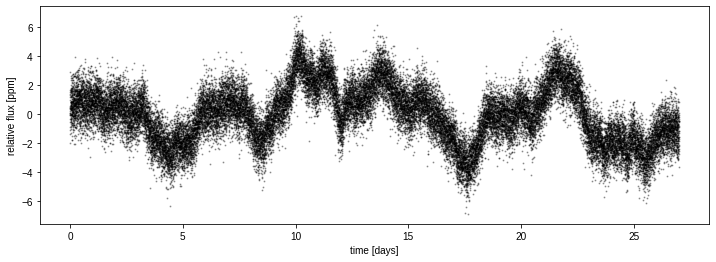

In [31]:
nreg = 100
df = pd.read_csv("problem2.csv")
t = np.array(df["time"])
flux = np.array(df["flux"])
flux_err = np.mean(np.array(df["flux_err"]))
A = np.hstack([np.array(df["A%03d" % n]).reshape(-1, 1) for n in range(nreg)])

# Plot it
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=2)
ax.set_ylabel("relative flux [ppm]")
ax.set_xlabel("time [days]");

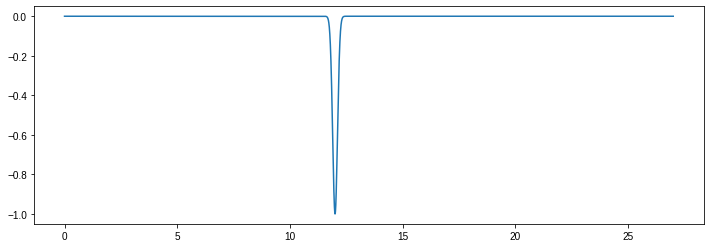

In [28]:
t0 = 12.0
sig_t = 0.15
transit_model = -np.exp(-(t - t0) ** 2 / sig_t ** 2)
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, transit_model);

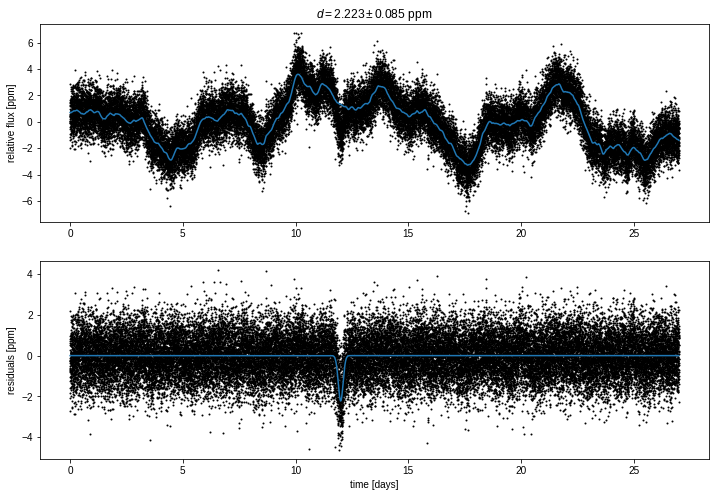

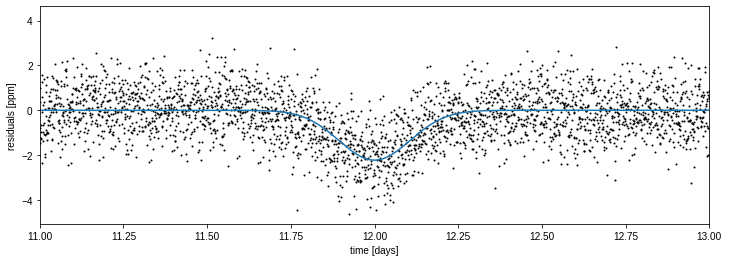

In [32]:
# Full design matrix
Anew = np.hstack((A, transit_model.reshape(-1, 1)))

# L2-regularized fit
lam = 1e-5
C = Anew.T.dot(Anew) / flux_err ** 2
C[np.diag_indices_from(C)] += np.append(1.0 / lam * np.ones(nreg), 0.0)
wnew = np.linalg.solve(C, Anew.T.dot(flux) / flux_err ** 2)

# Separate into systematics and transit weights
w = wnew[:-1]
depth = wnew[-1]

# The depth uncertainty
depth_err = np.sqrt(np.diag(np.linalg.inv(C))[-1])

# The systematics model
model = A.dot(w)

# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, flux, 'k.', alpha=1, ms=2);
ax[0].plot(t, model)
ax[0].set_ylabel("relative flux [ppm]")
ax[1].plot(t, flux - model, 'k.', alpha=1, ms=2)
ax[1].plot(t, depth * transit_model)
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("residuals [ppm]");

ax[0].set_title(r"$d = %.3f \pm %.3f$ ppm" % (depth, depth_err))

# Plot it (zoomed in)
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux - model, 'k.', alpha=1, ms=2)
ax.plot(t, depth * transit_model)
ax.set_xlabel("time [days]")
ax.set_ylabel("residuals [ppm]");
ax.set_xlim(11, 13);

In [33]:
flux_err

1.0

In [35]:
def emcee_logprior(params):
    loc, wid = params
    if not 10 < loc < 15:
        return -np.inf
    if not 0 < wid < 1:
        return -np.inf
    return np.log(1/30) + np.log(1)

def emcee_loglike(params):
    loc, wid = params
    model = -np.exp(-(t - loc) ** 2 / wid ** 2)
    Anew = np.hstack((A, model.reshape(-1, 1)))
    lam = 1e5
    C = np.dot(np.transpose(Anew),Anew) + 1e5*np.identity(101)
    wnew = np.linalg.solve(C, Anew.T.dot(flux))
    w = wnew[:-1]
    diff = flux - A.dot(w)-model
    return -0.5*np.dot(np.transpose(diff),diff)

def emcee_logprob(params):
    # I've actually implemented this function here for you
    lp = emcee_logprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + emcee_loglike(params)

In [40]:
np.random.seed(9281)
init = np.array([12.0, 0.15])
init = init + 0.1 * np.random.randn(10, 2)

emcee_sampler = emcee.EnsembleSampler(len(init), 2, emcee_logprob)
emcee_sampler.run_mcmc(init, 2500, progress=True);

100%|██████████| 2500/2500 [10:15<00:00,  4.12it/s]


In [41]:
tau = emcee_sampler.get_autocorr_time()
print("Integrated autocorrelation times:")
for i, k in enumerate(["bperp", "theta"]):
    print("{0}: {1}".format(k, tau[i]))
tau_max = int(tau.max())
emcee_samples = emcee_sampler.get_chain(discard=5*tau_max, flat=True)
#emcee_samples = np.array(emcee_samples.T).T

print("Effective number of samples for each parameter:")
print(len(emcee_samples) / emcee_sampler.get_autocorr_time(discard=5*tau_max))

Integrated autocorrelation times:
bperp: 30.05398489174772
theta: 30.292816309698026
Effective number of samples for each parameter:
[696.96400911 706.54928084]


In [42]:
emcee_samples.shape

(23500, 2)

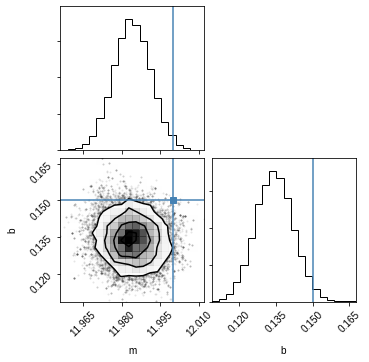

In [43]:
corner.corner(emcee_samples, labels=["m", "b"],
              truths=[12.0,0.15]);

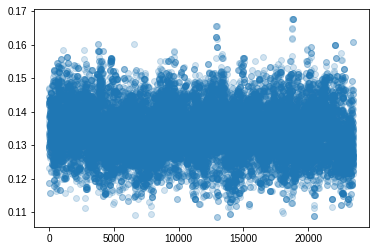

In [47]:
plt.plot(emcee_samples[:,1],'o', alpha=0.2)

In [1]:
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux - model, 'k.', alpha=1, ms=2)
for a in range(len(emcee_samples[:,1])/100):
    ax.plot(t,-np.exp(-(t - emcee_samples[a,0]) ** 2 / emcee_samples[a,1] ** 2), alpha =0.2)
ax.set_xlabel("time [days]")
ax.set_ylabel("residuals [ppm]");
ax.set_xlim(11, 13);

NameError: name 'plt' is not defined